In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import urllib3
from sklearn.metrics import classification_report
urllib3.disable_warnings()

In [ ]:
# 데이터셋 URL 수동 설정 (필요한 경우)
setattr(tfds.image_classification.cats_vs_dogs,
        '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs',
                                         split=['train[:80%]', 'train[80%:]'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

# 전처리 함수 정의
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])      # ResNet 입력 크기에 맞게 resize
    image = tf.cast(image, tf.float32) / 255.0       # 정규화
    return image, label

def apply_preprocessing(ds, batch_size=32, is_test=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = apply_preprocessing(ds_train, batch_size=32)
val_ds = apply_preprocessing(ds_test, batch_size=32, is_test=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.N2A5UK_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# ResNet 블록 정의
def residual_block(x_input, filters, stage, block, strides=1):
    conv_base = f"stage{stage}_{block}_conv"
    bn_base = f"stage{stage}_{block}_bn"
    add_name = f"stage{stage}_{block}_add"

    x = keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=True, name=f"{conv_base}1")(x_input)
    x = keras.layers.BatchNormalization(name=f"{bn_base}1")(x)
    x = keras.layers.Activation('relu', name=f"stage{stage}_{block}_relu1")(x)

    x = keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=True, name=f"{conv_base}2")(x)
    x = keras.layers.BatchNormalization(name=f"{bn_base}2")(x)

    shortcut = x_input
    if strides != 1 or x_input.shape[-1] != filters:
        shortcut = keras.layers.Conv2D(filters, 1, strides=strides, use_bias=True, name=f"{conv_base}_short")(x_input)
        shortcut = keras.layers.BatchNormalization(name=f"{bn_base}4")(shortcut)

    x = keras.layers.Add(name=add_name)([x, shortcut])
    x = keras.layers.Activation('relu', name=f"stage{stage}_{block}_relu2")(x)
    return x

In [ ]:
# ResNet-34 모델 구성
def build_resnet(input_shape=(224, 224, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape, name='input_layer')

    x = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=True, name='conv1_conv')(inputs)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.Activation('relu', name='conv1_relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1_pool')(x)

    for block in range(1, 4):
        x = residual_block(x, 64, stage=2, block=block)

    x = residual_block(x, 128, stage=3, block=1, strides=2)
    for block in range(2, 5):
        x = residual_block(x, 128, stage=3, block=block)

    x = residual_block(x, 256, stage=4, block=1, strides=2)
    for block in range(2, 7):
        x = residual_block(x, 256, stage=4, block=block)

    x = residual_block(x, 512, stage=5, block=1, strides=2)
    for block in range(2, 4):
        x = residual_block(x, 512, stage=5, block=block)

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    model = keras.Model(inputs, outputs, name='resnet34')
    return model

In [ ]:
# 모델 빌드 및 컴파일
resnet_34 = build_resnet()

resnet_34.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 모델 학습
history_resnet_34 = resnet_34.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 186s 238ms/step - accuracy: 0.5924 - loss: 0.7756 - val_accuracy: 0.5116 - val_loss: 0.9246
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.6250 - loss: 0.6489 - val_accuracy: 0.5920 - val_loss: 0.6764
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.6891 - loss: 0.5841 - val_accuracy: 0.5185 - val_loss: 1.4459
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.7514 - loss: 0.5082 - val_accuracy: 0.6515 - val_loss: 1.2619
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.8032 - loss: 0.4309 - val_accuracy: 0.7190 - val_loss: 0.5714
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.8323 - loss: 0.3743 - val_accuracy: 0.7745 - val_loss: 0.4695
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.8740 - loss: 0.2995 - val_accuracy: 0.8186 - val_loss: 0.3782
Epoch 8/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.8970 -

In [ ]:
import os

# 시각화 그래프
def plot_training_history(history, model_name='Model', save_dir='/content/drive/MyDrive/Resnet'):
    os.makedirs(save_dir, exist_ok=True)

    # Loss 시각화
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, f'{model_name}_Loss.png'))
    plt.close()

    # Accuracy 시각화
    if 'accuracy' in history.history or 'val_accuracy' in history.history:
        plt.plot(history.history.get('accuracy', []), label='train_accuracy')
        plt.plot(history.history.get('val_accuracy', []), label='val_accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, f'{model_name}_Accuracy.png'))
        plt.close()

In [ ]:
plot_training_history(history_resnet_34, model_name = 'resnet_34', save_dir='/content/drive/MyDrive/Resnet')

In [ ]:
def bottleneck_block(x_input, filters, stage, block, strides=1):
    conv_base = f"conv{stage}_block{block}_"
    bn_base = f"conv{stage}_block{block}_"

    shortcut = x_input

    x = keras.layers.Conv2D(filters, 1, strides=strides, padding='same',
                               use_bias=True, name=conv_base + '1_conv')(x_input)
    x = keras.layers.BatchNormalization(name=bn_base + '1_bn')(x)
    x = keras.layers.Activation('relu', name=bn_base + '1_relu')(x)

    x = keras.layers.Conv2D(filters, 3, strides=1, padding='same',
                               use_bias=True, name=conv_base + '2_conv')(x)
    x = keras.layers.BatchNormalization(name=bn_base + '2_bn')(x)
    x = keras.layers.Activation('relu', name=bn_base + '2_relu')(x)

    x = keras.layers.Conv2D(filters * 4, 1, strides=1, padding='same',
                               use_bias=True, name=conv_base + '3_conv')(x)
    x = keras.layers.BatchNormalization(name=bn_base + '3_bn')(x)

    if strides != 1 or x_input.shape[-1] != filters * 4:
        shortcut = tf.keras.layers.Conv2D(filters * 4, 1, strides=strides,
                                          use_bias=True, name=conv_base + '0_conv')(x_input)
        shortcut = tf.keras.layers.BatchNormalization(name=bn_base + '0_bn')(shortcut)

    x = keras.layers.Add(name=conv_base + 'add')([x, shortcut])
    x = keras.layers.Activation('relu', name=conv_base + 'out')(x)

    return x

In [ ]:
def build_resnet_50(input_shape=(224, 224, 3), num_classes=2, is_50=True):
    inputs = keras.Input(shape=input_shape, name='input_layer')

    x = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=True, name='conv1_conv')(inputs)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.Activation('relu', name='conv1_relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1_pool')(x)

    # Stage 2
    x = bottleneck_block(x, 64, stage=2, block=1, strides=1)
    for block in range(2, 4):
        x = bottleneck_block(x, 64, stage=2, block=block)

    # Stage 3
    x = bottleneck_block(x, 128, stage=3, block=1, strides=2)
    for block in range(2, 5):
        x = bottleneck_block(x, 128, stage=3, block=block)

    # Stage 4
    x = bottleneck_block(x, 256, stage=4, block=1, strides=2)
    for block in range(2, 7):
        x = bottleneck_block(x, 256, stage=4, block=block)

    # Stage 5
    x = bottleneck_block(x, 512, stage=5, block=1, strides=2)
    for block in range(2, 4):
        x = bottleneck_block(x, 512, stage=5, block=block)

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    model = keras.Model(inputs, outputs, name='resnet50')
    return model

In [ ]:
# 모델 빌드 및 컴파일
resnet_50 = build_resnet_50()

resnet_50.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_resnet_50 = resnet_50.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 267s 357ms/step - accuracy: 0.6008 - loss: 0.8093 - val_accuracy: 0.5209 - val_loss: 1.1139
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 314ms/step - accuracy: 0.6930 - loss: 0.5818 - val_accuracy: 0.6249 - val_loss: 1.3441
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 314ms/step - accuracy: 0.7558 - loss: 0.5124 - val_accuracy: 0.6184 - val_loss: 0.9200
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 314ms/step - accuracy: 0.7956 - loss: 0.4446 - val_accuracy: 0.7491 - val_loss: 0.5181
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 314ms/step - accuracy: 0.8383 - loss: 0.3736 - val_accuracy: 0.7896 - val_loss: 0.4637
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 314ms/step - accuracy: 0.8633 - loss: 0.3178 - val_accuracy: 0.8519 - val_loss: 0.3345
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 313ms/step - accuracy: 0.8936 - loss: 0.2604 - val_accuracy: 0.6997 - val_loss: 0.5551
Epoch 8/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 188s 314ms/step - accuracy: 0.9084 -

In [ ]:
plot_training_history(history_resnet_34, model_name = 'resnet_50', save_dir='/content/drive/MyDrive/Resnet')

In [ ]:
def plain_block(x, filters, stage, block, strides=1):
    conv_base = f"plain{stage}_{block}_conv"
    bn_base = f"plain{stage}_{block}_bn"

    x = keras.layers.Conv2D(filters, 3, strides=strides, padding='same',
                            use_bias=True, name=f"{conv_base}1")(x)
    x = keras.layers.BatchNormalization(name=f"{bn_base}1")(x)
    x = keras.layers.Activation('relu', name=f"{conv_base}_relu1")(x)

    x = keras.layers.Conv2D(filters, 3, strides=1, padding='same',
                            use_bias=True, name=f"{conv_base}2")(x)
    x = keras.layers.BatchNormalization(name=f"{bn_base}2")(x)
    x = keras.layers.Activation('relu', name=f"{conv_base}_relu2")(x)

    return x

In [ ]:
def build_plain34(input_shape=(224, 224, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape, name='input_layer')

    x = keras.layers.Conv2D(64, 7, strides=2, padding='same', name='conv1')(inputs)
    x = keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Stage 2 (3 blocks, 64 filters)
    for block in range(1, 4):
        x = plain_block(x, filters=64, stage=2, block=block)

    # Stage 3 (4 blocks, 128 filters)
    x = plain_block(x, filters=128, stage=3, block=1, strides=2)
    for block in range(2, 5):
        x = plain_block(x, filters=128, stage=3, block=block)

    # Stage 4 (6 blocks, 256 filters)
    x = plain_block(x, filters=256, stage=4, block=1, strides=2)
    for block in range(2, 7):
        x = plain_block(x, filters=256, stage=4, block=block)

    # Stage 5 (3 blocks, 512 filters)
    x = plain_block(x, filters=512, stage=5, block=1, strides=2)
    for block in range(2, 4):
        x = plain_block(x, filters=512, stage=5, block=block)

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    model = keras.Model(inputs, outputs, name='plainnet34')
    return model

In [ ]:
plain34 = build_plain34(input_shape=(224, 224, 3), num_classes=2)

plain34.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [ ]:
history_plain34 = plain34.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 165s 225ms/step - accuracy: 0.5299 - loss: 0.7236 - val_accuracy: 0.5099 - val_loss: 0.7210
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.5081 - loss: 0.6934 - val_accuracy: 0.5103 - val_loss: 0.7133
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.5159 - loss: 0.6949 - val_accuracy: 0.5142 - val_loss: 1.0692
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 202ms/step - accuracy: 0.5644 - loss: 0.6859 - val_accuracy: 0.5387 - val_loss: 0.7097
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 123s 202ms/step - accuracy: 0.5808 - loss: 0.6768 - val_accuracy: 0.5178 - val_loss: 0.9893
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6052 - loss: 0.6611 - val_accuracy: 0.6148 - val_loss: 0.6579
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6142 - loss: 0.6520 - val_accuracy: 0.5217 - val_loss: 0.7848
Epoch 8/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6291 -

In [ ]:
plot_training_history(history_plain34, model_name = 'plain_34', save_dir='/content/drive/MyDrive/Resnet')

In [ ]:
def plain_bottleneck_block(x_input, filters, stage, block, strides=1):
    conv_base = f"stage{stage}_{block}_conv"
    bn_base = f"stage{stage}_{block}_bn"

    x = keras.layers.Conv2D(filters, 1, strides=strides, padding='same',
                            use_bias=True, name=f"{conv_base}1")(x_input)
    x = keras.layers.BatchNormalization(name=f"{bn_base}1")(x)
    x = keras.layers.Activation('relu', name=f"{conv_base}_relu1")(x)

    x = keras.layers.Conv2D(filters, 3, strides=1, padding='same',
                            use_bias=True, name=f"{conv_base}2")(x)
    x = keras.layers.BatchNormalization(name=f"{bn_base}2")(x)
    x = keras.layers.Activation('relu', name=f"{conv_base}_relu2")(x)

    x = keras.layers.Conv2D(filters * 4, 1, strides=1, padding='same',
                            use_bias=True, name=f"{conv_base}3")(x)
    x = keras.layers.BatchNormalization(name=f"{bn_base}3")(x)
    x = keras.layers.Activation('relu', name=f"{conv_base}_relu3")(x)

    return x

In [ ]:
def build_plain50(input_shape=(224, 224, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape, name='input_layer')

    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=True, name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Stage 2 (3 bottleneck blocks, 64 filters → output: 256 channels)
    x = plain_bottleneck_block(x, 64, stage=2, block=1, strides=1)
    for block in range(2, 4):
        x = plain_bottleneck_block(x, 64, stage=2, block=block)

    # Stage 3 (4 bottleneck blocks, 128 filters → output: 512 channels)
    x = plain_bottleneck_block(x, 128, stage=3, block=1, strides=2)
    for block in range(2, 5):
        x = plain_bottleneck_block(x, 128, stage=3, block=block)

    # Stage 4 (6 bottleneck blocks, 256 filters → output: 1024 channels)
    x = plain_bottleneck_block(x, 256, stage=4, block=1, strides=2)
    for block in range(2, 7):
        x = plain_bottleneck_block(x, 256, stage=4, block=block)

    # Stage 5 (3 bottleneck blocks, 512 filters → output: 2048 channels)
    x = plain_bottleneck_block(x, 512, stage=5, block=1, strides=2)
    for block in range(2, 4):
        x = plain_bottleneck_block(x, 512, stage=5, block=block)

    # Classification head
    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='fc')(x)

    model = tf.keras.Model(inputs, outputs, name='plain50')
    return model

In [ ]:
plain50 = build_plain34(input_shape=(224, 224, 3), num_classes=2)

plain50.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [ ]:
history_plain50 = plain50.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 165s 226ms/step - accuracy: 0.5018 - loss: 0.7581 - val_accuracy: 0.5232 - val_loss: 0.7249
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.5659 - loss: 0.6754 - val_accuracy: 0.5647 - val_loss: 0.6873
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6001 - loss: 0.6587 - val_accuracy: 0.5890 - val_loss: 0.7159
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6408 - loss: 0.6345 - val_accuracy: 0.5899 - val_loss: 0.9489
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6582 - loss: 0.6226 - val_accuracy: 0.6447 - val_loss: 0.6631
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.6975 - loss: 0.5799 - val_accuracy: 0.6032 - val_loss: 0.7093
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 204ms/step - accuracy: 0.7044 - loss: 0.5703 - val_accuracy: 0.7186 - val_loss: 0.5544
Epoch 8/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 124s 204ms/step - accuracy: 0.7296 -

In [ ]:
plot_training_history(history_plain50, model_name = 'plain_50', save_dir='/content/drive/MyDrive/Resnet')

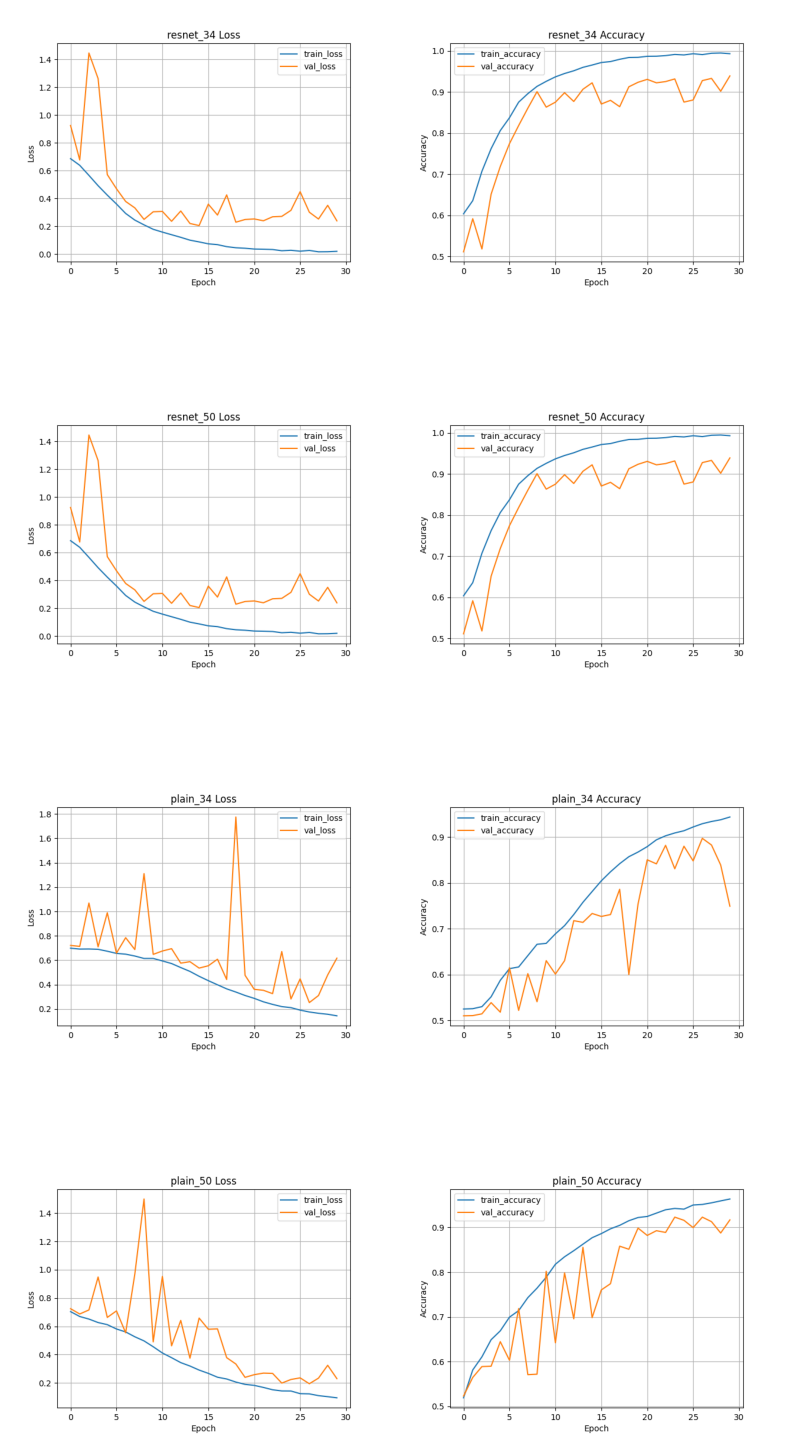

In [2]:
# 그래프 비교
import matplotlib.pyplot as plt
from PIL import Image


image_paths = [
    "/content/drive/MyDrive/Resnet/resnet_34_Loss.png",
    "/content/drive/MyDrive/Resnet/resnet_34_Accuracy.png",
    "/content/drive/MyDrive/Resnet/resnet_50_Loss.png",
    "/content/drive/MyDrive/Resnet/resnet_50_Accuracy.png",
    "/content/drive/MyDrive/Resnet/plain_34_Loss.png",
    "/content/drive/MyDrive/Resnet/plain_34_Accuracy.png",
    "/content/drive/MyDrive/Resnet/plain_50_Loss.png",
    "/content/drive/MyDrive/Resnet/plain_50_Accuracy.png"
]

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_paths):
        img = Image.open(image_paths[i])
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()